In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train = train.sample(frac=1)
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
def get_image_from_df(df):
    pix_cols = [column for column in df.columns if 'pixel' in column]
    images = df[pix_cols].to_numpy()
    images = images.reshape(-1, 28, 28, 1)
    y = None
    if 'label' in df.columns:
        y = df['label'].to_numpy().reshape(-1)
        y = tf.convert_to_tensor(y)
    
    images = tf.convert_to_tensor(images)
    return images, y

In [5]:
images_train, y_train = get_image_from_df(train)
images_test, _ = get_image_from_df(test)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [96]:
# train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.05)
# train_datagen = ImageDataGenerator(rescale=1/255,
#                                    validation_split=0.05)
train_datagen = ImageDataGenerator(rescale=1/255)

# train_flow = train_datagen.flow(images_train, y_train, batch_size=200)
train_flow = train_datagen.flow(images_train,
                                y_train,
                                batch_size=200,
                                subset='training')
validation_flow = train_datagen.flow(images_train,
                                     y_train,
                                     batch_size=100,
                                     subset='validation')

In [97]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


In [98]:
# history = model.fit(train_flow, validation_data=validation_flow, epochs=50)
# # history = model.fit(train_flow, epochs=100)

In [99]:
class CNNBlock(tf.keras.Model):
    def __init__(self, kernels, kernel_size=2):
        super(CNNBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(kernels, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.conv2 = tf.keras.layers.Conv2D(kernels, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.concatenate = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.concatenate([x, inputs])
        return self.act(x)

class DNNBlock(tf.keras.Model):
    def __init__(self, units):
        super(DNNBlock, self).__init__()
        self.fc1 = tf.keras.layers.Dense(units)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.fc2 = tf.keras.layers.Dense(units)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.concatenate = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.bn1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.concatenate([x, inputs])
        return self.act(x)

class ResNet(tf.keras.Model):
    def __init__(self, num_classes, kernels=128, kernel_size=3):
        super(ResNet, self).__init__()
        self.cnn_block = CNNBlock(kernels, kernel_size)
        self.flatten = tf.keras.layers.Flatten()
        self.dnn_block1 = DNNBlock(128)
        self.dnn_block2 = DNNBlock(128)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    def call(self, inputs):
        x = self.cnn_block(inputs)
        x = self.flatten(x)
        x = self.dnn_block1(x)
        x = self.dnn_block2(x)
        return self.out(x)

In [100]:
model = ResNet(10)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.build((None, 28, 28, 1))

model.summary()

history = model.fit(train_flow,
                    validation_data=validation_flow,
                    epochs=15)

Model: "res_net_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_block_32 (CNNBlock)     multiple                  149888    
                                                                 
 flatten_13 (Flatten)        multiple                  0         
                                                                 
 dnn_block_14 (DNNBlock)     multiple                  12963072  
                                                                 
 dnn_block_15 (DNNBlock)     multiple                  12979456  
                                                                 
 dense_51 (Dense)            multiple                  1013930   
                                                                 
Total params: 27,106,346
Trainable params: 27,104,810
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/15
200/200 [====================

In [74]:
y_pred = model.predict(images_test/255)

875/875 [==============================] - 3s 4ms/step


In [75]:
y_pred = y_pred.argmax(axis=1)

In [76]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [77]:
pd.DataFrame(y_pred, columns=['Label'], index=range(1, len(y_pred)+1)).to_csv('submission.csv', index_label='ImageId', index=True)

In [78]:
tf.math.confusion_matrix(y_train, model.predict(images_train/255).argmax(axis=1))

1313/1313 [==============================] - 5s 4ms/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[4131,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0, 4678,    0,    1,    0,    0,    0,    5,    0,    0],
       [   2,    3, 4135,   10,    1,    1,    0,   25,    0,    0],
       [   1,    0,    0, 4345,    0,    4,    0,    0,    0,    1],
       [   1,    4,    0,    0, 4053,    0,    0,    6,    0,    8],
       [   0,    0,    0,    4,    0, 3790,    1,    0,    0,    0],
       [   3,   10,    0,    0,    1,    3, 4120,    0,    0,    0],
       [   0,    5,    0,    2,    0,    0,    0, 4394,    0,    0],
       [  15,    2,    4,   25,    1,    5,    3,    1, 3992,   15],
       [   1,    3,    0,    1,   11,    3,    0,   10,    0, 4159]],
      dtype=int32)>

2


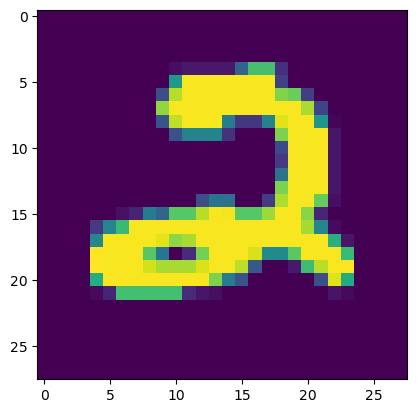

0


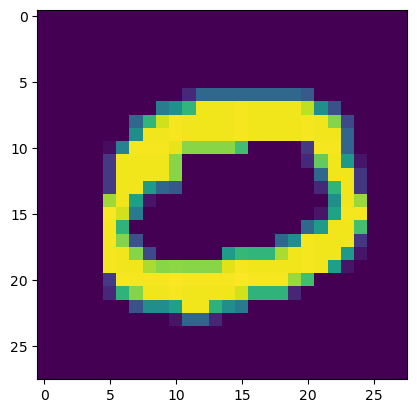

9


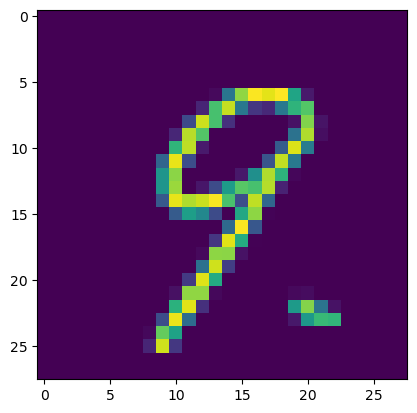

0


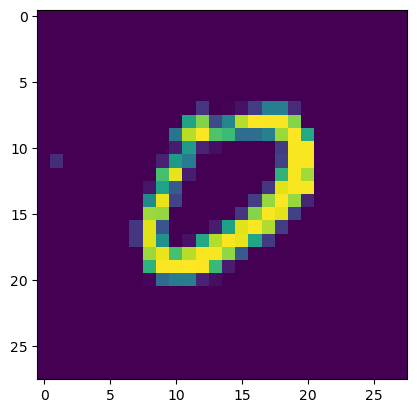

3


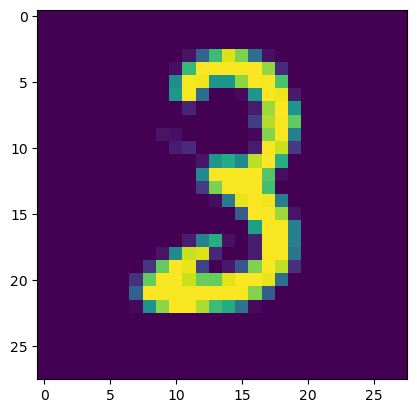

7


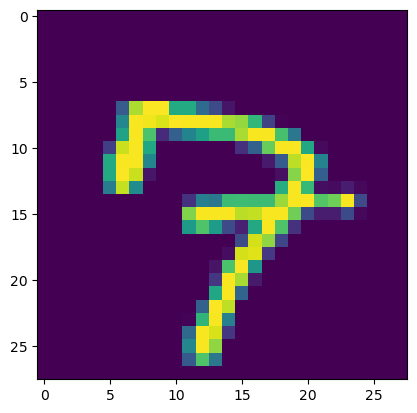

0


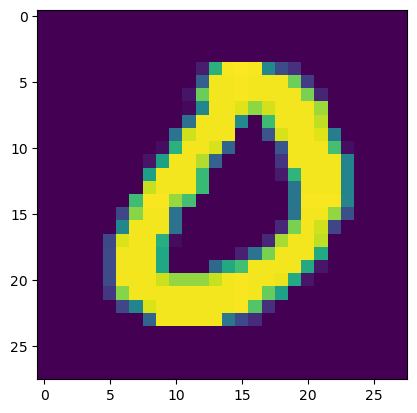

3


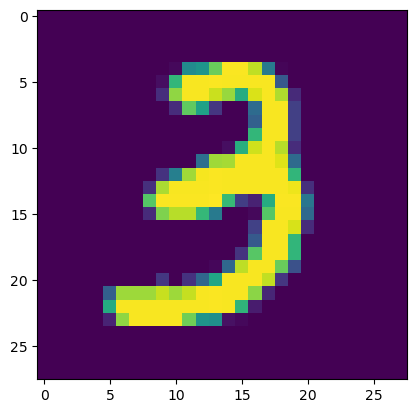

0


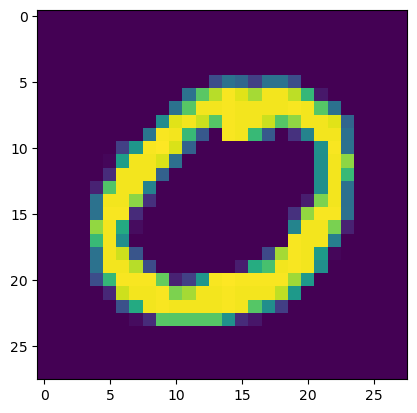

3


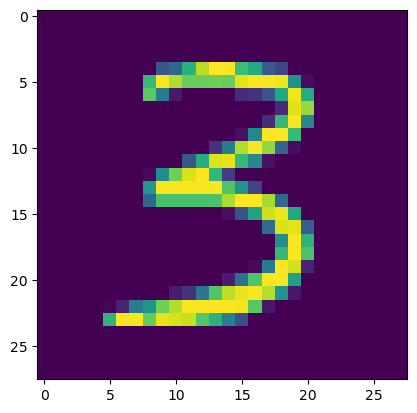

5


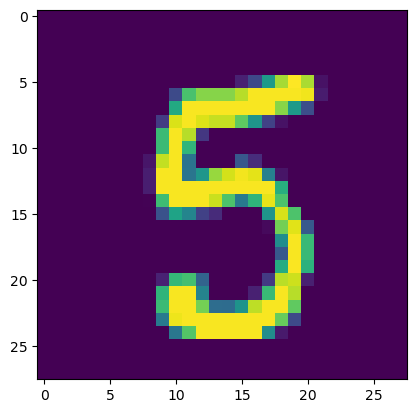

7


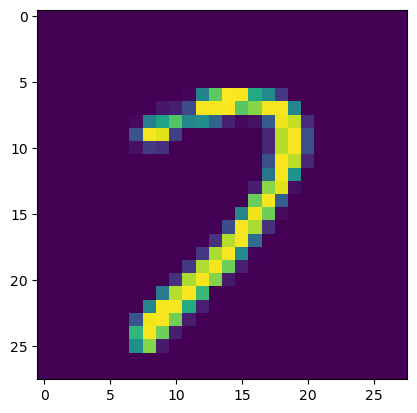

4


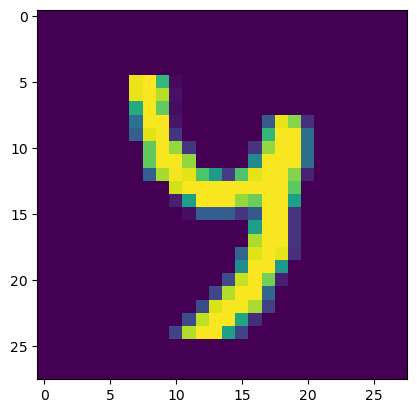

0


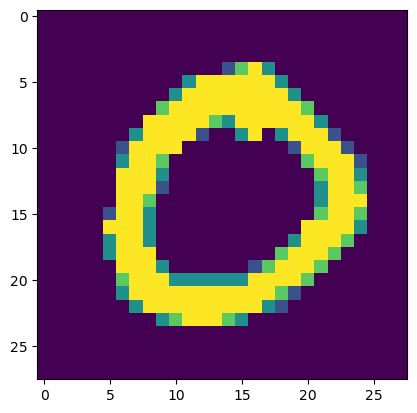

4


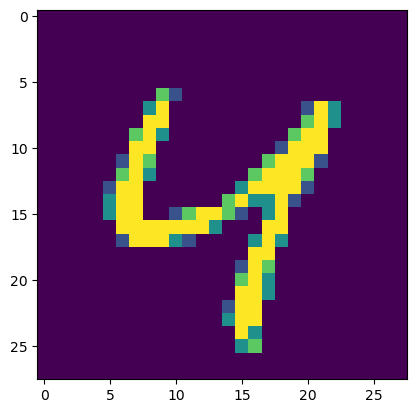

3


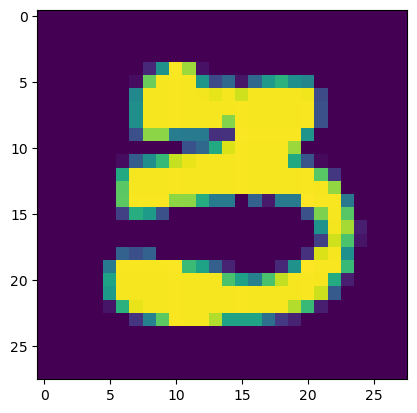

3


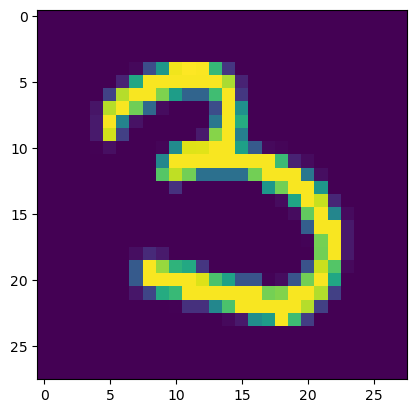

1


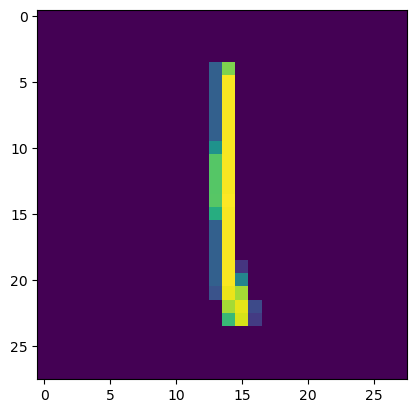

9


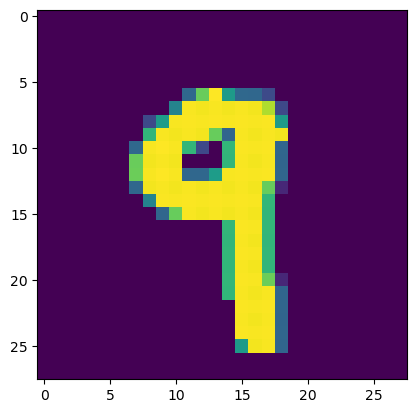

0


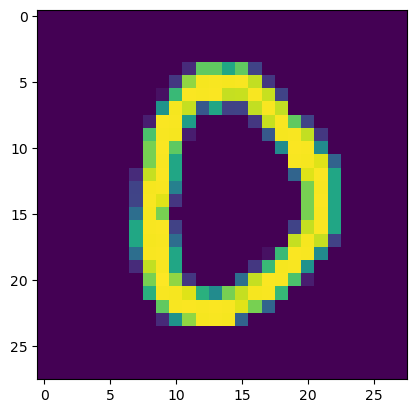

9


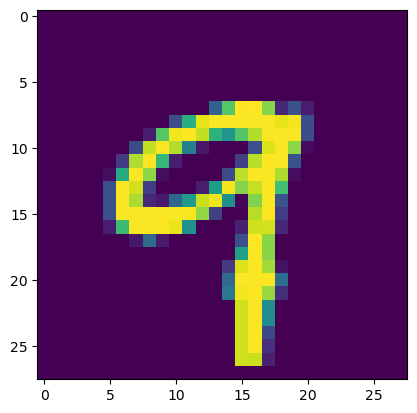

1


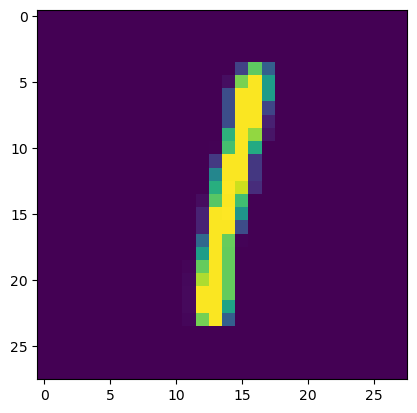

1


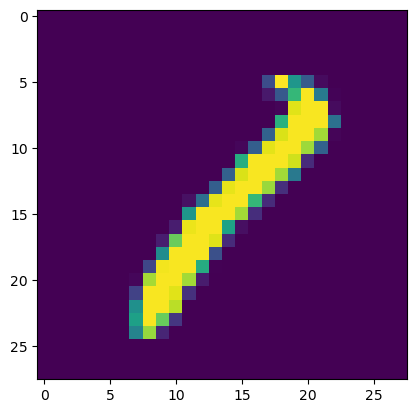

5


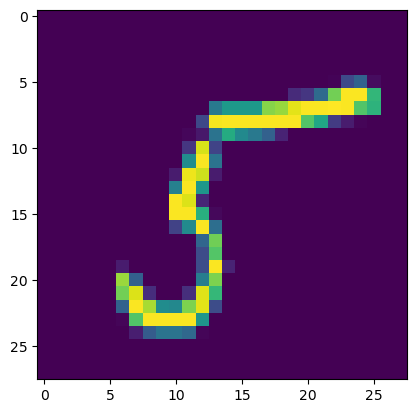

7


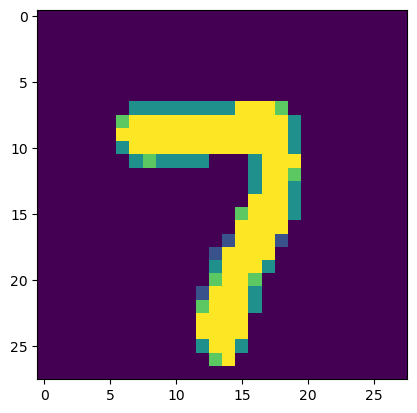

4


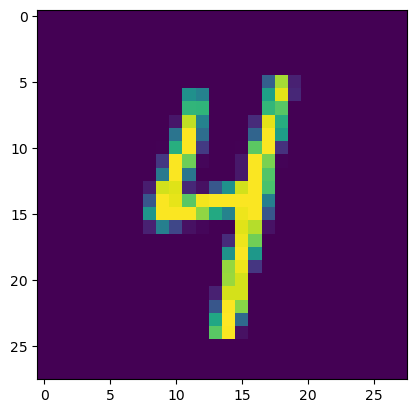

2


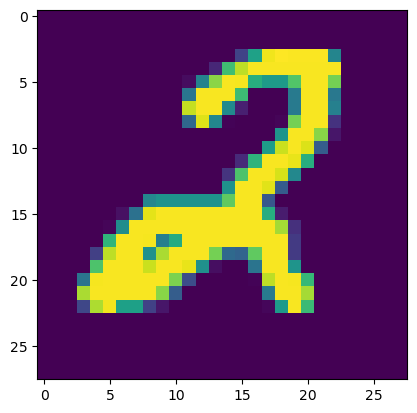

7


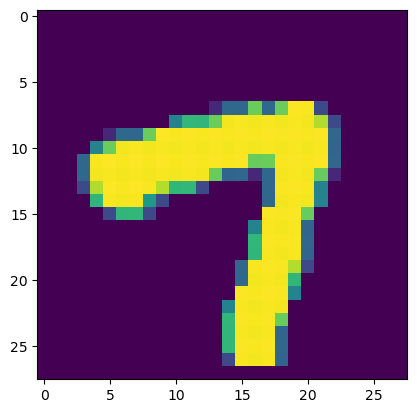

4


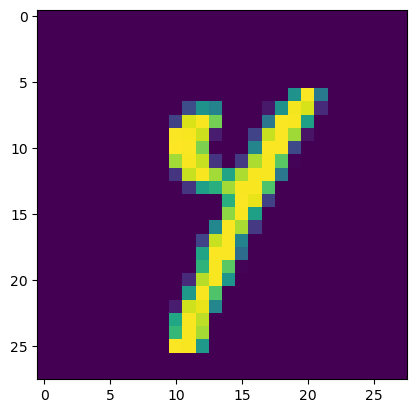

7


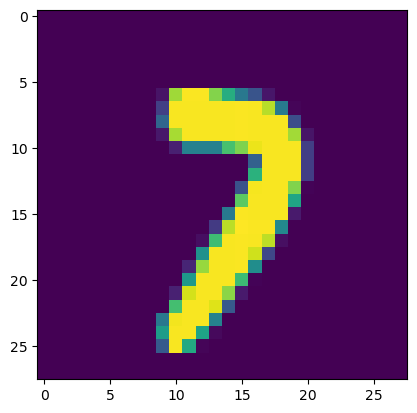

7


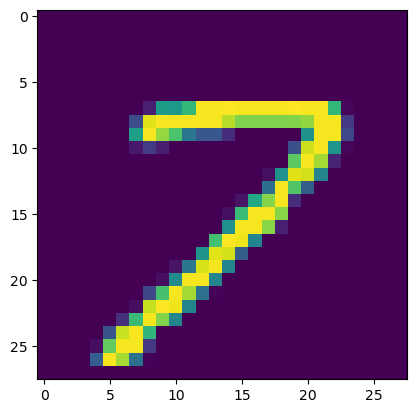

5


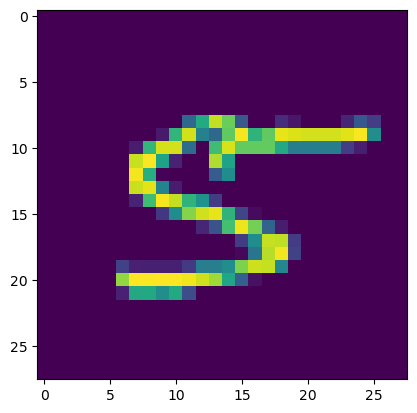

4


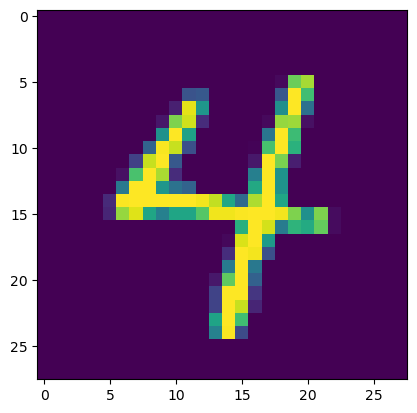

2


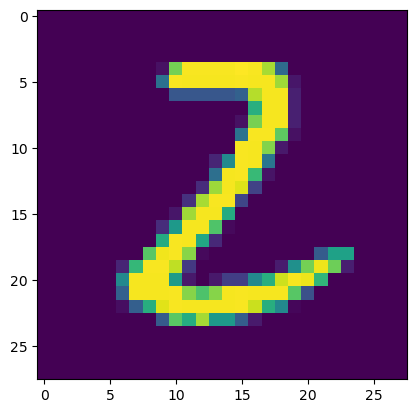

6


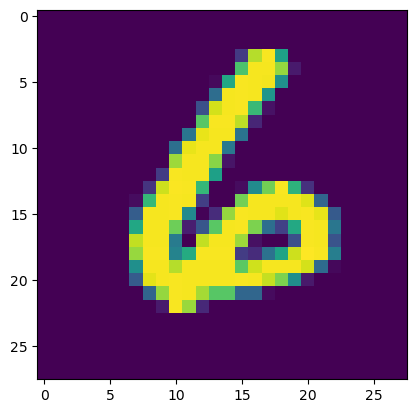

2


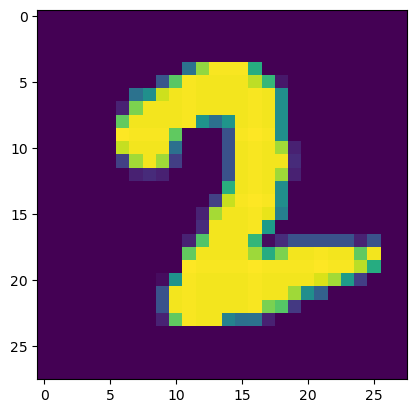

5


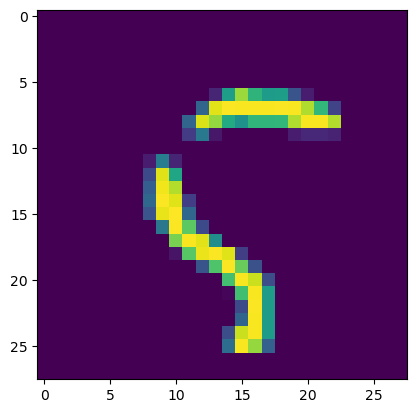

5


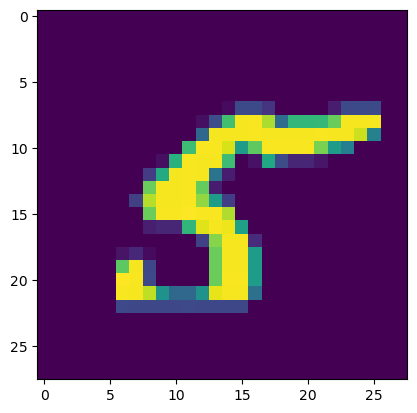

1


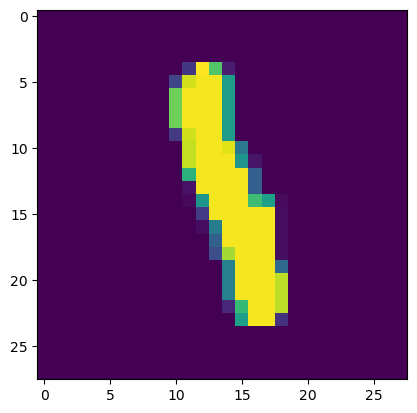

6


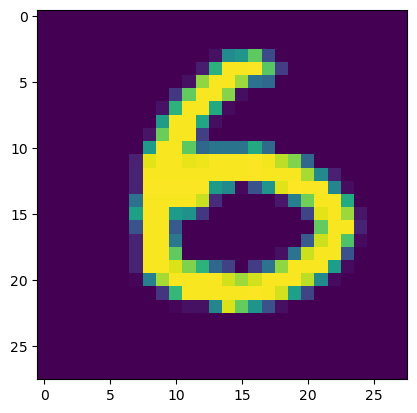

7


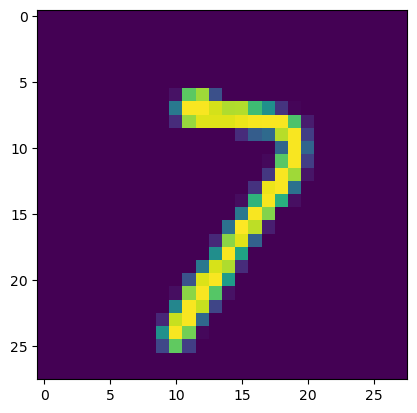

7


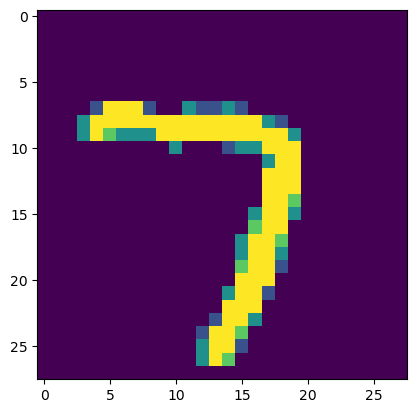

4


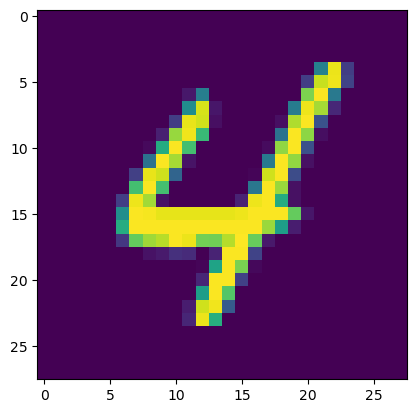

9


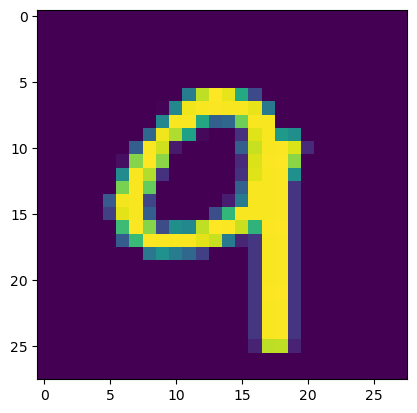

8


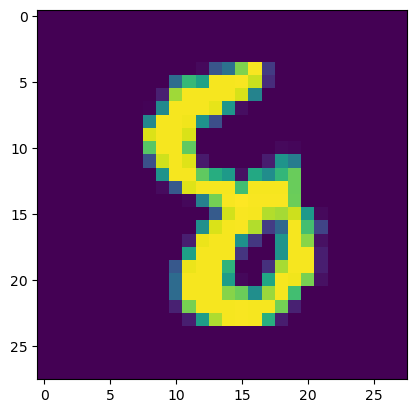

7


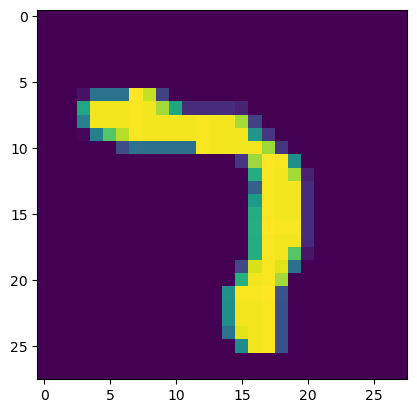

8


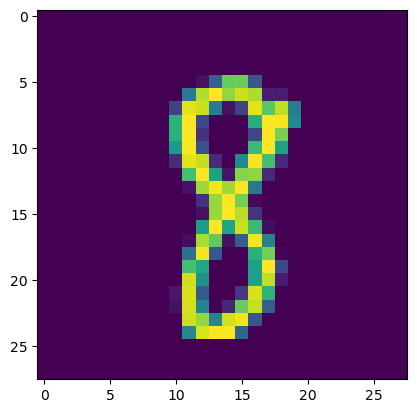

2


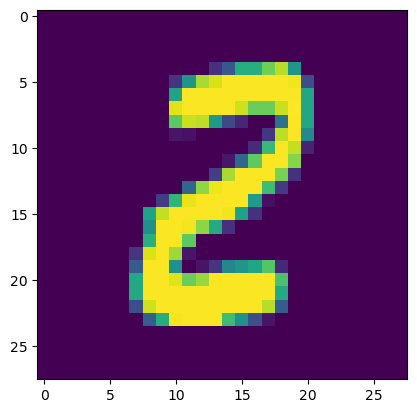

6


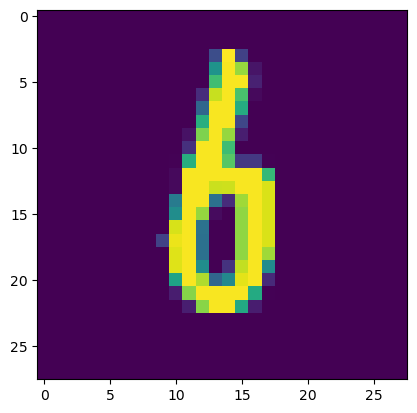

7


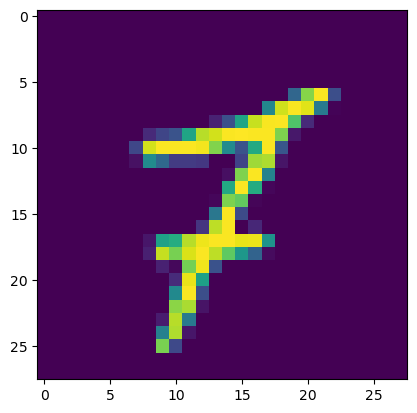

6


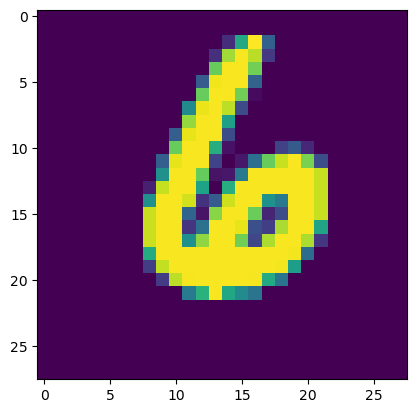

8


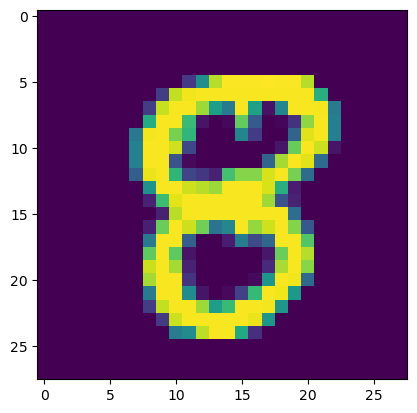

8


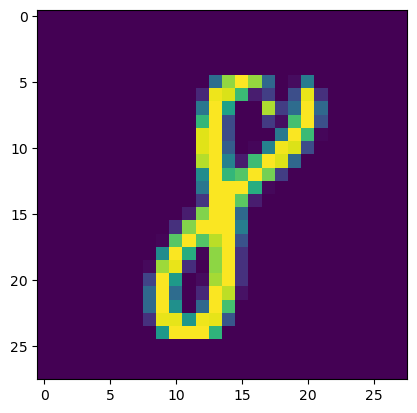

3


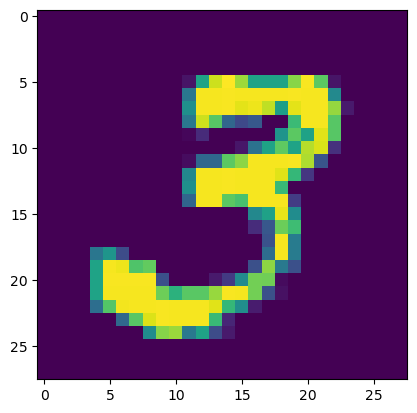

8


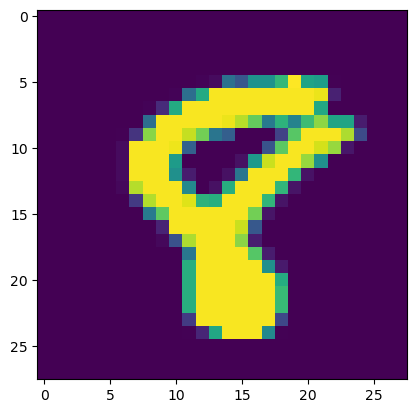

2


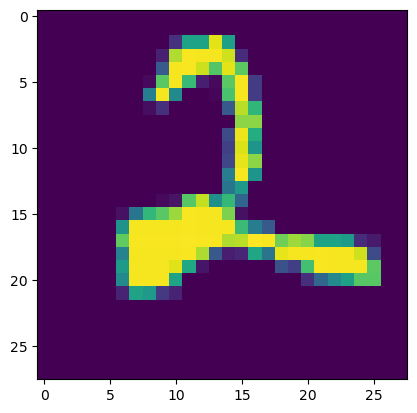

1


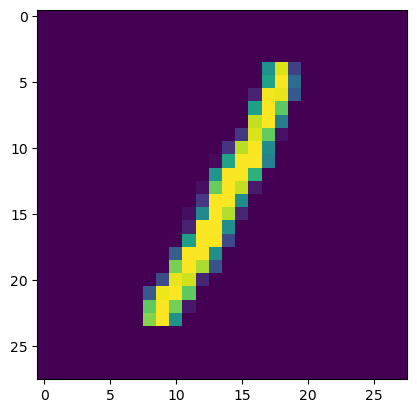

2


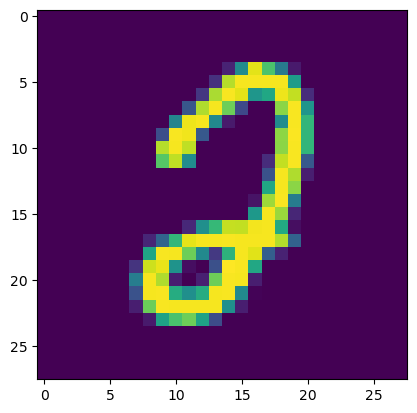

2


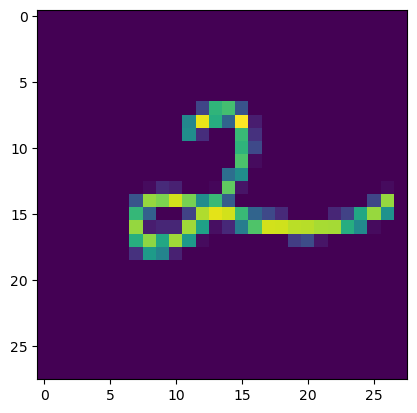

0


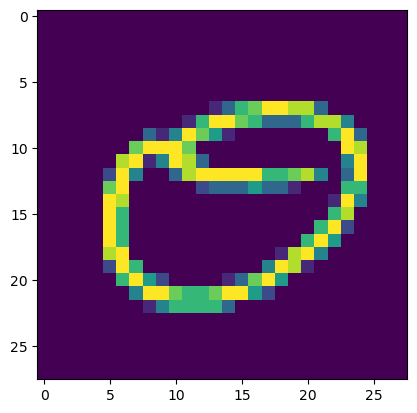

4


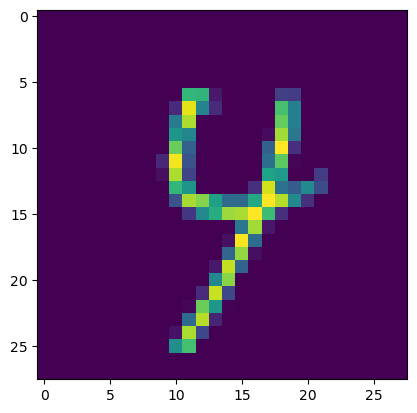

1


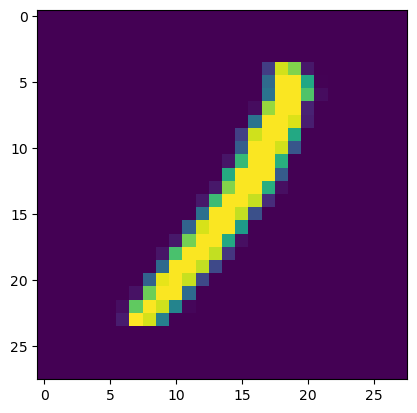

7


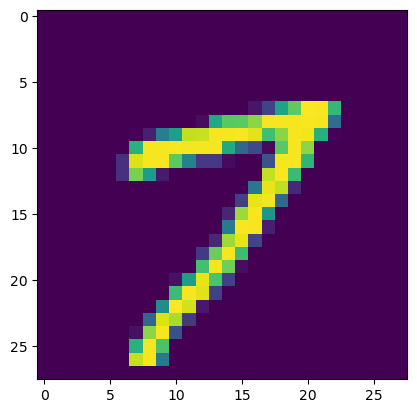

0


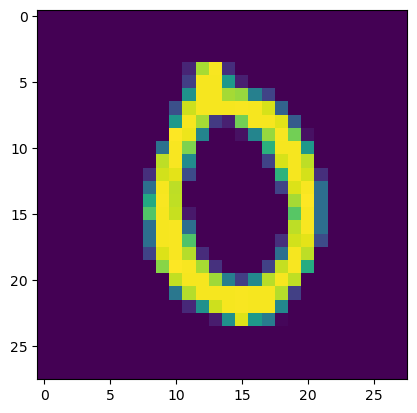

0


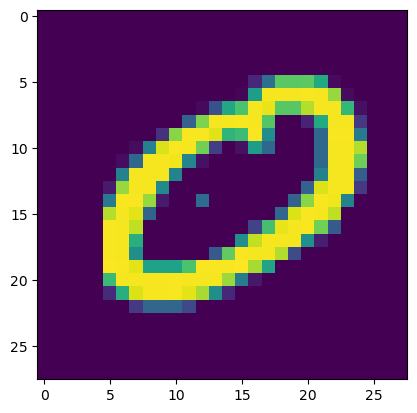

0


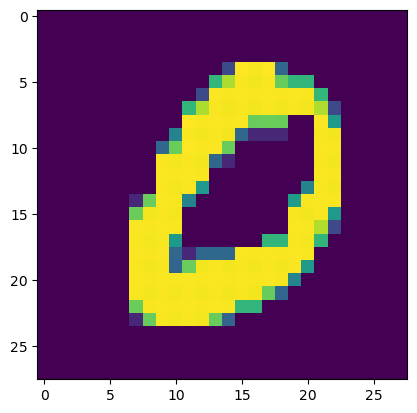

1


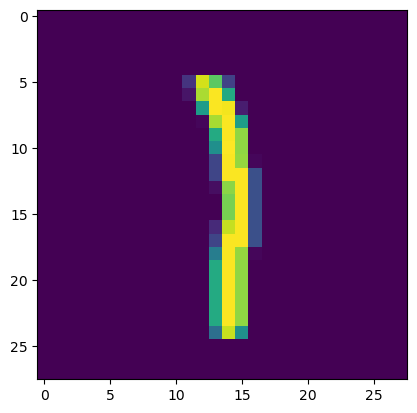

9


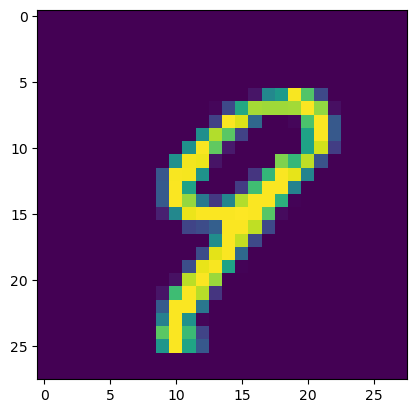

0


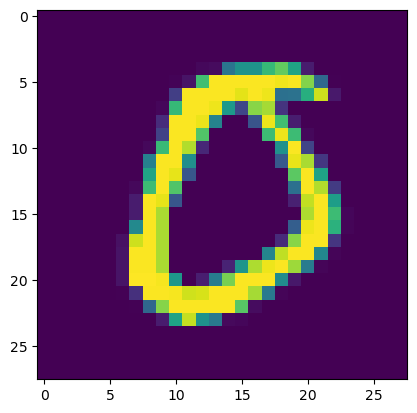

1


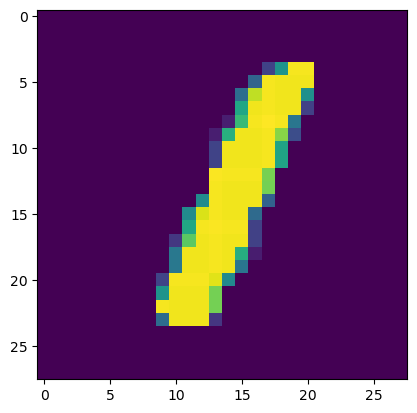

6


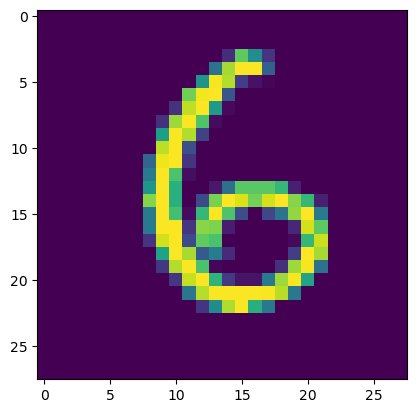

5


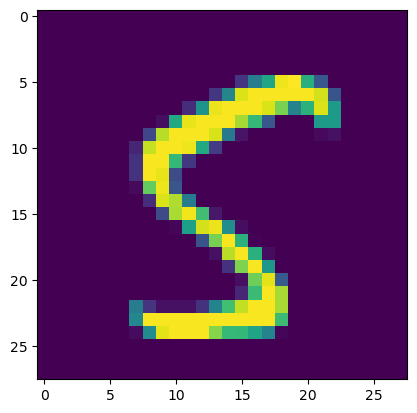

8


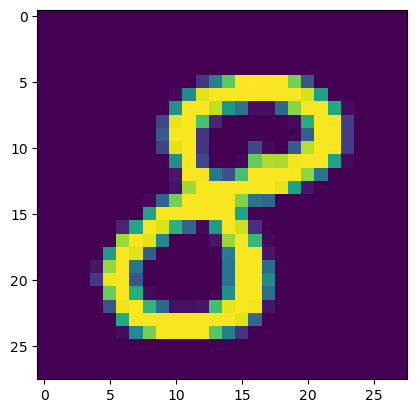

8


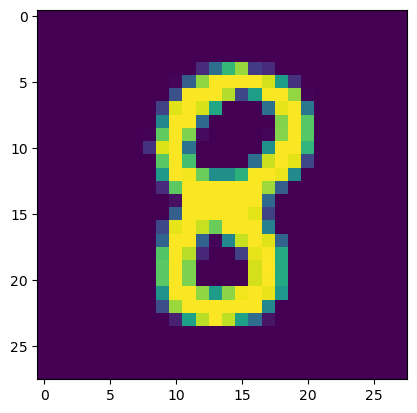

2


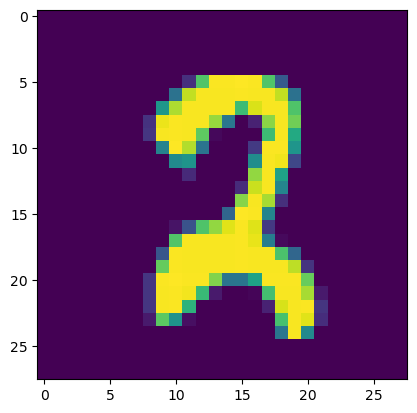

8


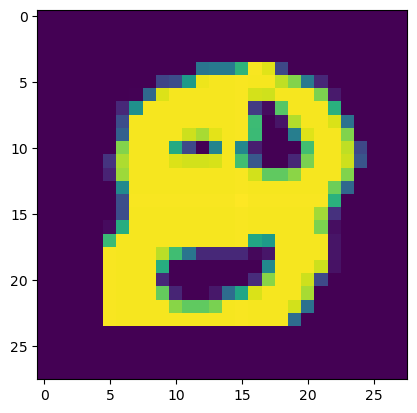

9


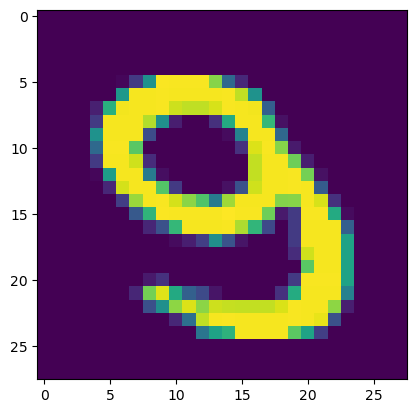

9


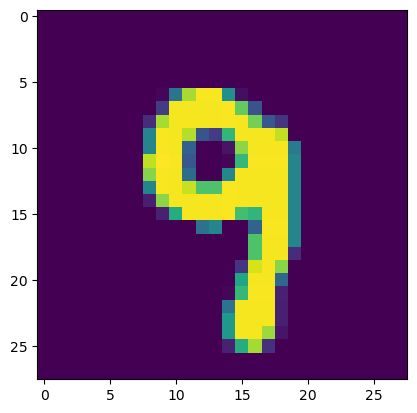

2


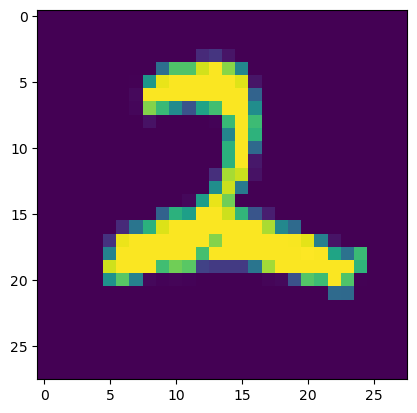

3


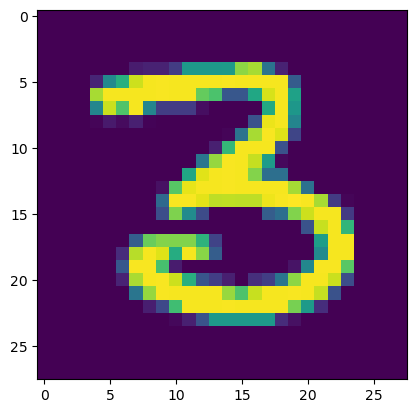

5


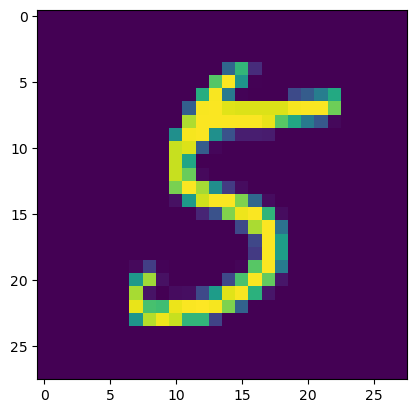

4


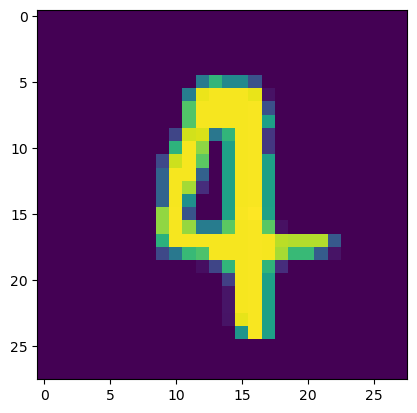

KeyboardInterrupt: 

In [95]:
import matplotlib.pyplot as plt
import time
for i in range(len(y_pred)):
  print(y_pred[i])
  plt.imshow(images_test[i].numpy().squeeze(-1))
  plt.show()
  time.sleep(1)